# Goal of notebook
- parse xml files of BTLF (ONIX format)
- generate book, publisher and authors for BLTF compatible with knowledge base of BNF / BTLF
- match publishers of BNF_Constellation with publishers of BTLF
    -> hybrid exact and manual matching because editor names are tricky
    -> generate btlf books with editors consolidated with BNF/ BTLF

# prerequisite
- onix files
- manual_matches_v2 from alignement_editeurs_analyse.ipynb:

# output
- btlf book file
- bltf/bnf/constellation aligned editors
- btlf autors (not aligned, have to execute alignement_auteurs.ipynb)

# Création du graphe BTLF



In [14]:
from rdflib import Graph, Namespace, Literal, URIRef
from rdflib import RDF, RDFS, OWL, XSD
import collections
import sys
sys.path.append('../../../')
sys.path.append('../../../andre')

import andre.utils as utils
from andre.utils import schema as SCHEMA
from andre.utils import pbs as PBS
import isbnlib

# Récupération des documents XML

In [15]:
import xml.etree.ElementTree as ET
filePattern = "../Onix_synapseC_2/202312181524_onix3_M3_{}.xml"


ns = { 'd': "http://ns.editeur.org/onix/3.0/reference" }


items = [] 
for n in range (0, 13):
    file = filePattern.format(n)
    data = ET.parse(file)
    root = data.getroot()
    products = root.findall("./d:Product", ns)
    items += products
    

print(len(items), " livres au total")

26920  livres au total


# Extraction des informations à partir des documents XML

In [16]:
import xml.etree.ElementTree as ET

productIdenfifier = {
    "01" : "Proprietary",
    "02" : "ISBN-10",
    "03" : "GTIN-13",
    "06" : "DOI",
    "13" : "LCCN" ,
    "15" : "ISBN-15",
}


productForm = {
    "00" : "Undefined",
    "BA" : "Book",
    "BB" : "Hardback",
    "BC" : "Paperback / softback",
    "BH" : "Board book",
    "BE" : "Spiral bound", 
    "SB" : "Multiple-component retail product, boxed",
    "SA" : "Multiple-component retail product",
    "ED" : "Digital download",
    "BO" : "Fold-out book or chart",
    "BD" : "Loose-leaf",
    "SF" : "Multiple-component retail product, part(s) enclosed",
    "AC" : "CD-Audio",
    "ZZ" : "Other merchandise"
}


primaryContentType = {
    "10" : "Text",   
}


titleElementLevel = {
    "01" : "Product",
    "02" : "Collection level",
    "03" : "Subcollection"   
}

titleDetail = {
    "00" : "Undefined",
    "01" : "Distinctive title (book); Cover title (serial); Title on item (serial content item or reviewed resource)",
    "02" : "ISSN key title of serial",
    "03" : "Title in original language",
    "04" : "Title acronym or initialism",
    "05" : "Abbreviated title",
    "06" : "Title in other language",
    "08" : "Former title", 
    "14" : "Alternative title",
}

contributorRole = {
    "A01" : "By (author)",
    "A02" : "With",
}

languageRole = {
    "01" : "Language of text",
    "02" : "Original language of a translated text",
}

subjectSchema = {
    "01" : "Dewey",
    "10" : "BISAC",
    "23" : "Publisher's own category",
    "93" : "Thema",
    "94" : "Thema place qualifier"   
}

pusblishingRole = {
    "01" : "Publisher",
    "10" : "Publishing group"
}

textType = {
    "03" : "Description",
    "06" : "Review quote",    
    "10" : "Promotional headline",
}


editeursQuebecois = [
    "Alire",
    "Atma",
    "Bayard Canada",
    "Bravo!",
    "Chouette",
    "De la Bagnole",
    "Édimag",
    "Fonfon",
    "Glénat Québec",
    "JCL",
    "La Courte échelle",
    "La Griffe",
    "La Mèche",
    "La Semaine",
    "Le Jour",
    "Les Éditions de l'Hexagone",
    "Les Éditions du Journal",
    "Les Éditions Québec-Livres",
    "Les Presses Libres",
    "Libre Expression",
    "Logiques",
    "Marcel Broquet Éditeur",
    "Marchand de feuilles",
    "Michel Quintin",
    "Monde Différent (Un)",
    "Parfum d'encre",
    "Perro éditeur",
    "Petit homme",
    "Presses Aventure",
    "Publistar",
    "Recto-Verso",
    "Soulières Éditeur",
    "Stanké",
    "Trécarré",
    "Typo",
    "VLB éditeur",
    "Wilson & Lafleur",
    "Z'Ailées",
]

# exclu: 
## PC10 = jeunes adultes: >18ans
## PC08 =  Tranche d'âge spécifique: pas de connaissance de la tranche d'age
## PC12 = public motivé: ne peut pas deduire age
## PC13 = professionel: surement > à 18 ans
## NS06 = Universitaire: > 18ans
## PC11 = adultes

# correspondance age/ niveau scolaires -> voir image
age_ranges = {
    "PC03" : [0, 1, 2, 3],
    "PC04" : [3, 4, 5, 6],
    "PC05" : [6, 8, 9],
    "PC06" : [9, 10, 11, 12],
    "PC07" : [12, 13, 14, 15],
    "PC01" : [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], # Tout Public: > 8 ans car sinon, longueur et format livre incompatible entre ages extrêmes
    "NS03" : [12, 13, 14, 15, 16],
    "NS02" : [6, 7, 8, 9, 10, 11],
    "NS01" : [0, 1, 2, 3, 4, 5], # prescolaire: < 6 ans
    "NS05" : [17, 18] # college = CEGEP
    }

age_ranges_str = {
    "PC03" : ["0", "1", "2", "3"],
    "PC04" : ["3", "4", "5", "6"],
    "PC05" : ["6", "8", "9"],
    "PC06" : ["9", "10", "11", "12"],
    "PC07" : ["12", "13", "14", "15"],
    "PC01" : ["8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18"]

    }

# Correspondance Age/ Niveau Scolaire
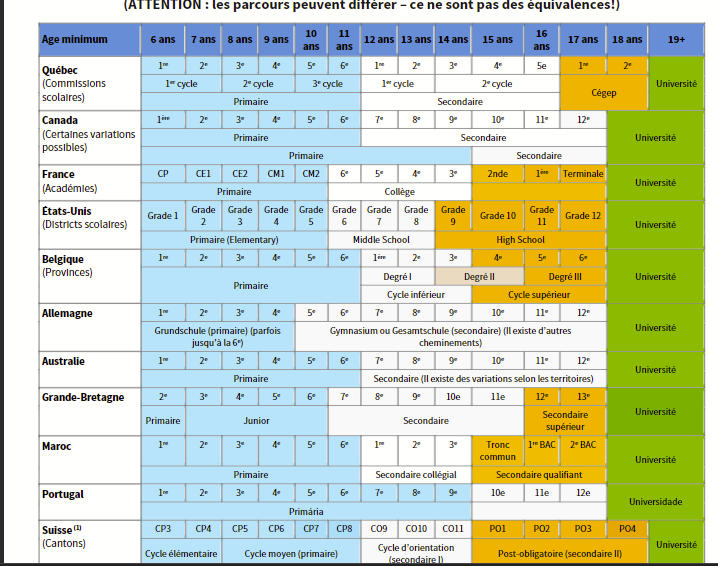

# Création du graphe RDF

In [17]:
from rdflib import Graph, Namespace, Literal, URIRef
from rdflib import RDF


SCHEMA = Namespace("http://schema.org/")
DCTERMS = Namespace("http://purl.org/dc/terms/")
DBO = Namespace("http://dbpedia.org/ontology/")
PBS = Namespace("http://www.example.org/pbs#")



In [18]:
graphe_Editeurs = Graph()
graphe_Editeurs.bind("schema","http://schema.org/", override=True, replace=True)

## Création du graphe des auteurs


In [19]:
graphe_Auteurs = Graph()
graphe_Auteurs.bind("schema","http://schema.org/", override=True, replace=True)
graphe_Auteurs.bind("pbs","http://www.example.org/pbs#", override=True)
graphe_Auteurs.bind("author","http://schema.org/Person", override=True, replace=True)

id = 0
auteurs = {} # clé = Nom, Prénom
for item in items:
    editeur = item.findall(".//d:PublishingRole[.='01']../d:PublisherName", ns) 
    if not editeur:
        print('ERREUR',item)   

    liste_auteurs = item.findall('.//d:DescriptiveDetail/d:Contributor', ns)
    for a in liste_auteurs: 
        nom = a.find(".//d:PersonNameInverted", ns)
        if nom == None:
            continue
        if nom.text not in auteurs:
            id += 1
            auteurs[nom.text] = SCHEMA['author' + str(id)]
            graphe_Auteurs.add((SCHEMA['author' + str(id)],RDF.type, SCHEMA['Person']))
            nom_prenom = nom.text.rsplit(",")
            if len(nom_prenom) == 2:
                nom_famille = nom_prenom[0].strip()
                prenom = nom_prenom[1].strip()
                graphe_Auteurs.add((SCHEMA['author' + str(id)],SCHEMA.givenName,Literal(prenom)))
                graphe_Auteurs.add((SCHEMA['author' + str(id)],SCHEMA.familyName,Literal(nom_famille)))
            elif len(nom_prenom) == 1: # pseudonyme ex: Barasui ou nom/prenom pas clairement défini ex: Vieira da Silva
                nom_famille = nom_prenom[0].strip()
                graphe_Auteurs.add((SCHEMA['author' + str(id)],SCHEMA.familyName,Literal(nom_famille)))
                # print(nom.text)
            else:
                print(nom.text)

                
            bio = a.findall('./d:BiographicalNote', ns)
            if bio:
                graphe_Auteurs.add((SCHEMA['author' + str(id)],SCHEMA.description	,Literal(bio[0].text)))

Saint-Mars, Dominique, de


Linden, Martijn, van der
Preux, Anne, de
Boyce, Frank, Cottrell
La Fontaine, Jean, de
Leeuwen, Joke, van
El Fathi, Mickaël, el
Panafieu, Jean-Baptiste, de
Vendel, Edward, van de
Berge, Marieke, ten
Lestrade, Agnès, de
Bolduc, Edouard, Mme
Laubier, Matthieu, de
Saint-Chamas, Benoît, de
Saint-Chamas, Emmanuelle, de
Chantérac, Inès, de


In [20]:
fichier = open("../Graphes/grapheAuteursBTLF_new_data.ttl","wb")
graphe_Auteurs.serialize(fichier) 
fichier.close()

In [11]:
print(len(auteurs),'auteurs')
print(len(graphe_Auteurs), 'triplets')

18219 auteurs
54240 triplets


## Création du graphe des éditeurs

In [21]:
def find_publisher_by_raw_name(target_raw_name):
    for preprocessed_name in publishers_bnf_constellations_dict.keys(): # defined later
        raw_name = publishers_bnf_constellations_dict[preprocessed_name].raw_name
        # print(uri)
        if raw_name == target_raw_name:
            return publishers_bnf_constellations_dict[preprocessed_name]
    return "not found"

In [8]:
publishers_bnf_constellations_graph = Graph()
publishers_bnf_constellations_graph.bind("schema","http://schema.org/", override=True, replace=True)
publishers_bnf_constellations_graph.parse("../../old or intermediary files/publisher_BNF_Constellation_NoDuplicate.ttl")

publishers_bnf_constellations_dict = {}
doublons = []
for publisher in publishers_bnf_constellations_graph.subjects(RDF.type, SCHEMA.Publisher):
    raw_name = str(publishers_bnf_constellations_graph.value(publisher, SCHEMA.name))
    preprocessed_name = utils.preprocess_publisher_name(raw_name)

    
    if preprocessed_name in publishers_bnf_constellations_dict.keys():
        doublons.append(preprocessed_name)
    else: 
        publishers_bnf_constellations_dict[preprocessed_name] = utils.Publisher(source="bnf_constellations", 
                                                                        uri=publisher, 
                                                                        raw_name=raw_name, 
                                                                        preprocessed_name=preprocessed_name)

print(len(doublons)) # should be 0 because loading the NoDuplicate file
print(len(list(publishers_bnf_constellations_graph.subjects(RDF.type, SCHEMA.Publisher))))
len(publishers_bnf_constellations_dict)

0
2228


2228

## editor consolidation

In [11]:
manual_matches_v2 = { # every single match here is been verified, but not all of it is used (some keys were used before changing publisher to imprint )
'Gulf Stream (Editions du)': 
   'Gulf Stream',
'Magnard-Vuibert': 
   'Magnard',
'Musée du Louvre': 
   'Musée du Louvre éd.',
'Soleil productions': 
   'Soleil production',
'Editions Ouest-France-Edilarge': 
   'Ouest-France',
'Plume de carotte': 
   'Plume carotte',
'Editions Dadoclem': 
   'Dadoclem éd.',
'Jean-Claude Gawsewitch éditeur': 
   'J.-C. Gawsewitch',
"Editions de L'Archipel": 
   "L'Archipel",
'Odile Jacob': 
   'O. Jacob',
'Editions du Centre Pompidou': 
   'Centre Pompidou',
'Musées de la ville de Strasbourg': 
   'les Musées de la Ville de Strasbourg',
'Lancosme multimédia': 
   'Lancosme éd.',
'Critères': 
   'Critères éd.',
'Quespire': 
   'Quespire éd.',
'Les éditions du Bonhomme vert': 
   'le Bonhomme vert',
'Vengeur masqué': 
   'Le Vengeur Masqué',
'Editions Ecole active': 
   "L'École active",
'Editions [MiC_MaC]': 
   'Mic-Mac',
'Eveil et découvertes': 
   'Eveil et découverte',
'Editions des Grandes personnes': 
   'Les Grandes Personnes',
'Editions-Diffusion Karthala': 
   'Karthala',
'Les éditions Carpentier': 
   'D. Carpentier',
'Pascal Galodé éditeurs': 
   'P. Galodé',
'Prisma Media': 
   'Prisma',
'Art à la page': 
   "l'Art à la page",
'CERCIL': 
   'du Cercil',
'Les Editions de la Grande ourse': 
   'La Grande Ourse',
'Editions de La Différence': 
   'La Différence',
'Tertium': 
   'Tertium éd.',
'Editions de la Renarde rouge': 
   'La Renarde Rouge',
'Aniss éditions': 
   'Aniss éd.',
'Editions du Rouergue': 
   'Rouergue',
'Les éditions du soleil de minuit': 
   'Soleil De Minuit',
'Editions des Arènes': 
   'Les Arènes',
'Le Square éditeur': 
   'le Square éd.',
'Griffon bleu': 
   'le Griffon bleu',
'Les éditions du Kilowatt': 
   'Kilowatt',
'Ophelbe': 
   'Ofelbe',
'Editions Privat SAS': 
   'Privat',
'Losange': 
   'du Losange',
'Les Editions Sandawe': 
   'Sandawe.com',
'Nouvelles éditions ivoiriennes': 
   'NEI - Nouvelles éditions Ivoiriennes',
'Studio des Trois Becs': 
   'Studio les Trois Becs',
'Editions Imago': 
   'Auzas éditeurs-Imago',
'205 Corp': 
   '205.fr',
'Librairie Téqui (Pierre)': 
   'Téqui',
'Editions de la Coopérative': 
   'la Coopérative',
'Les Productions Somme toute': 
   'Somme toute',
'Réseau Canopé': 
   'Canopé éditions',
'Editions Maelström': 
   'maelstrÖm reEvolution',
'Le Dilettante': 
   'Le dilletante',
'Les Editions de Minuit': 
   'Minuit',
'Editions Jean-Paul Gisserot': 
   'J.-P. Gisserot',
'Les éditions du dernier havre': 
   'Le dernier havre',
'Éditions du Septentrion': 
   'Septentrion',
'Orca Book Publishing': 
   'Orca',
'LéR - Les éditeurs réunis': 
   'Les Éditeurs Réunis',
"Presses de l'Université de Montréal": 
   'Les Presses De L’université De Montréal',
'Éditions du Noroit': 
   'Le Noroît',
'Editions de Fallois': 
   'Fallois',
'6 pieds sous terre éditions': 
   'Six Pieds Sous Terre',
'Editions du Triomphe': 
   'Triomphe',
'Éditions du Vermillon': 
   'Vermillon',
'Éditions ADA inc.': 
   'AdA',
"Homme sans nom (Editions de l')": 
   "L'Homme Sans Nom",
'Editions des Mille saisons': 
   'Mille Saisons',
'Vincze (Eva)': 
   'É. Vincze',
'Edizioni Corraini': 
   'Corraini',
'Editions Picquier (Philippe)': 
   'P. Picquier',
"Ed. de l'Homme sans nom": 
   "L'Homme Sans Nom",
'Jaguar': 
   'du Jaguar',
'Palissade': 
   'La Palissade',
'Note de partage': 
   'une Note de partage',
'Privat SAS': 
   'Privat',
'Marmaille et compagnie': 
   'Marmaille & compagnie',
'Alain Gorius': 
   'al Manar-A. Gorius',
'Harmattan Guinée': 
   "l'Harmattan Guinée",
'les Ed. Ago': 
   'AGO',
'Louvre éditions': 
   'Musée du Louvre éd.',
'Calicot': 
   'le Calicot',
"Aventuriers de l'étrange": 
   "les Aventuriers de l'étrange",
'Revue dessinée': 
   'La Revue dessinée',
'Diplodocus': 
   'le Diplodocus',
'Nouv. éd. ivoiriennes': 
   'NEI - Nouvelles éditions Ivoiriennes',
"Museum d'histoire naturelle": 
   "Muséum national d'histoire naturelle",
'Musée cantonal des beaux-arts de Lausanne': 
   'Musée des beaux-arts de Lausanne',
'Editions Deux-Cent-Cinq': 
   '205.fr',
'Inédite': 
   "l'Inédite",
"Néva éd.":"Neva",
"Ed. des Mille saisons": 
   "Mille Saisons",
"Sorbier":"Le Sorbier",
"Quadrants":"Quadrant",
"Rouge et or":"Rouge & Or",
"Nuée bleue": 
   "la Nuée bleue",
"Rocher": 
   "du Rocher",
"EP Emmanuel Proust éditions": 
   "Emmanuel Proust",
"Petit Lézard": 
   "Le Petit lézard",
"Afrobul":
   "Afro bulles éd.",
"Atalante": 
   "L'Atalante",
"Cherche Midi": 
   "Le Cherche Midi",
"Courrier du livre": "le Courrier du livre",
"Cité des sciences & de l'industrie":
   "Cité des sciences et de l'industrie",
"Ecole des loisirs":
   "L'École Des Loisirs",
"De La Martinière Jeunesse":
   "La Martinière Jeunesse",
"Temps apprivoisé":
   "le Temps apprivoisé",
"Archipel":
   "L'Archipel",
"Ecole active":
   "L'École active",
"Blake et Mortimer":
   "Blake & Mortimer",
"les Ed. du jardin des mots":
   "du Jardin des mots",
"M. Lafon": 
   "Michel Lafon",
"les Ed. du bonhomme vert":
   "le Bonhomme vert",
"Fond du Tiroir (Le)":
   "le Fond du tiroir",
"Ed. des Grandes personnes":
   "Les Grandes Personnes",
"Éditions de la Bagnole":
   "La Bagnole",
"les Ed. Fei":
   "Fei",
"Tulipe noire":
   "la Tulipe noire",
"Joie de lire":
   "La Joie De Lire",
"Temps des cerises":
   "le Temps des cerises",
"Orbestier":
   "d'Orbestier",
"Ed. de la Gouttière":
   "La Gouttière",
"Éditions Hurtubise inc.":
   "Hurtubise",
"Ed. de la Renarde rouge":
   "La Renarde Rouge",
"S. Diantantu":
   "Diantantu Editions",
"Arche éditeur":
   "L'Arche",
"Rocher jeunesse":
   "Le Rocher Jeunesse",
"Éditions de l'Isatis":
   "Isatis",
"Agrume":
   "L'Agrume",
"Petites moustaches éditions (Les)":
   "les Petites moustaches",
"Square éditeur":
   "le Square éd.",
"Cosmographe":
   "le Cosmographe",
"Harmattan Mali":
   "l'Harmattan Mali",
"Tropique édition":
   "Tropiques",
"Ed. du Centre Pompidou":
   "Centre Pompidou",
"Lattès":
   "JC Lattès",
"Atelier des Noyers":
   "l'Atelier des noyers",
"Lac aux Fées":
   "le lac aux fées",
"Le Robert":
   "Robert",
"Éditions du Phoenix":
   "Du Phœnix",
"Saint-Jean":
   "Guy Saint-Jean",
"Éditions du Trécarré":
   "Trécarré",
"Humanoïdes associés":
   "Les Humanoïdes Associés",
"Beech Street Books (French)":
   "Beech Street Books",
"Ed. de Fallois":
   "Fallois",
"Pré-aux-Clercs":
   "Le Pré Aux Clercs",
"Éditions de l'Hexagone":
   "L'Hexagone",
"6 pieds sous terre":
   "Six Pieds Sous Terre",
"Ed. de l'Olivier":
   "L'Olivier"
 }
 
id = 0

# editeurs = {}
btlf_publishers_dict = {}
doublons_btlf = []
exact_match_counter = 0
manual_match_counter = 0
no_match_counter = 0
    
for root in items:

    # raw_names = root.findall(".//d:PublishingRole[.='01']../d:PublisherName", ns) 
    raw_names = root.findall(".//d:ImprintIDType[.='01']../../d:ImprintName", ns)

    if not raw_names:
        print('ERREUR', root)
    for raw_name in raw_names:

        raw_name = raw_name.text
        preprocessed_name = utils.preprocess_publisher_name(raw_name)
    
        if preprocessed_name in btlf_publishers_dict.keys():
            doublons_btlf.append(preprocessed_name)
        else:
            btlf_publishers_dict[preprocessed_name] = raw_name
            # if "paquet" in preprocessed_name:
            #     print("\""+ raw_name+ "\"")
            if preprocessed_name in publishers_bnf_constellations_dict.keys(): # don't change graph
                exact_match_counter += 1 
            elif raw_name in manual_matches_v2.keys(): # don't change graph
                # but: avoir uri du truc matché
                manual_match_counter += 1
                matched_raw_name = manual_matches_v2[raw_name]
                print(matched_raw_name)
                matched_publisher = find_publisher_by_raw_name(matched_raw_name)
                print(matched_publisher)
                publishers_bnf_constellations_graph.add((SCHEMA[matched_publisher.uri], SCHEMA.name, Literal(matched_publisher.raw_name, datatype=utils.xsd.string))) # ajouter le nom pour tester les matches et avertir de 2 noms possible pour maison edition
            else:
                no_match_counter += 1
                uri = raw_name.replace(' ', '_').replace("'", "").replace("&", "_").replace("/", "_").replace(".", "")
                # print(uri)
                uri = URIRef(f'{SCHEMA}{uri}')
                publishers_bnf_constellations_graph.add((uri, RDF.type, SCHEMA.Publisher))
                publishers_bnf_constellations_graph.add((uri, SCHEMA.name, Literal(raw_name, datatype=utils.xsd.string)))
                preprocessed_name = utils.preprocess_publisher_name(raw_name)
                publishers_bnf_constellations_dict[preprocessed_name] = utils.Publisher(source="btlf", 
                                                                        uri=uri, 
                                                                        raw_name=raw_name, 
                                                                        preprocessed_name=preprocessed_name)
    
# print(editeurs)
print("direct", exact_match_counter)
print("manual", manual_match_counter)
print("no match", no_match_counter)

L'École Des Loisirs
uri = http://schema.org/LÉcole_Des_Loisirs, 
  source = bnf_constellations,
  raw_name = L'École Des Loisirs,
  preprocessed_name = lecoledesloisirs
La Martinière Jeunesse
uri = http://schema.org/La_Martinière_Jeunesse, 
  source = bnf_constellations,
  raw_name = La Martinière Jeunesse,
  preprocessed_name = lamartinierejeunesse
L'Arche
uri = http://schema.org/LArche, 
  source = bnf_constellations,
  raw_name = L'Arche,
  preprocessed_name = larche
Le Rocher Jeunesse
uri = http://schema.org/Le_Rocher_Jeunesse, 
  source = bnf_constellations,
  raw_name = Le Rocher Jeunesse,
  preprocessed_name = lerocherjeunesse
Musée du Louvre éd.
uri = http://schema.org/MuseduLouvred, 
  source = bnf_constellations,
  raw_name = Musée du Louvre éd.,
  preprocessed_name = museedulouvre
Centre Pompidou
uri = http://schema.org/CentrePompidou, 
  source = bnf_constellations,
  raw_name = Centre Pompidou,
  preprocessed_name = centrepompidou
Les Humanoïdes Associés
uri = http://schem

In [15]:
# fichier = open("../Graphes/publishers_BTLF_BNF_Constellations.ttl","wb")
# publishers_bnf_constellations_graph.serialize(fichier) 
# fichier.close()

In [16]:
print(len(graphe_Editeurs))

0


## Création du graphe des livres

In [12]:
graphe_Livres = Graph()
graphe_Livres.bind("schema","http://schema.org/", override=True, replace=True)
graphe_Livres.bind("pbs","http://www.example.org/pbs#", override=True)

exact_match_counter = 0
manual_match_counter = 0
no_match_counter = 0

class BTLF_Book():
    def __init__(self, btlf_id, isbn=None, name=None, author=None, publisher=None, date=None):
        self.btlf_id = btlf_id
        self.isbn = isbn
        self.name = name
        self.author = author
        self.publisher = publisher
        self.date = date
    
    def __eq__(self, other):
        if( self.btlf_id == other.btlf_id
            and self.isbn == other.isbn 
            and self.name == other.name
            and self.author == other.author
            and self.publisher == other.publisher
            and self.date == other.date):
            return True
        else:
            return False


duplicate_books = collections.defaultdict(lambda: [])

livres = []
for root in items:
    rf = root.find('.//d:RecordReference', ns)

    # if rf.text in duplicate_books:
    #     print("duplicate", rf.text)

    btlf_book_object = BTLF_Book(btlf_id=rf.text)
    
    graphe_Livres.add((SCHEMA[rf.text], RDF.type, SCHEMA['Book']))
    graphe_Livres.add((SCHEMA[rf.text], PBS.infoSource, PBS.BTLF))

    editeursLivre = root.findall(".//d:ImprintIDType[.='01']../../d:ImprintName", ns)


    for raw_name in editeursLivre:
        raw_name = raw_name.text
        preprocessed_name = utils.preprocess_publisher_name(raw_name)
        btlf_book_object.publisher = raw_name
        # print(preprocessed_name)
        if preprocessed_name in publishers_bnf_constellations_dict.keys():
            exact_match_counter += 1
            publisher_uri = publishers_bnf_constellations_dict[preprocessed_name].uri
            graphe_Livres.add((SCHEMA[rf.text], SCHEMA.publisher, publisher_uri))
        elif raw_name in manual_matches_v2.keys():
            manual_match_counter += 1
            # print(raw_name)
            matched_raw_name = manual_matches_v2[raw_name]
            matched_publisher = find_publisher_by_raw_name(matched_raw_name)
            graphe_Livres.add((SCHEMA[rf.text], SCHEMA.publisher, matched_publisher.uri))
        else:
            no_match_counter += 1
            # print("# si pas trouvé avec le preprocessed name, forcement dans le dict")
        
    liste_auteurs = root.findall('.//d:Contributor', ns)
    if len(liste_auteurs) > 0:
        for a in liste_auteurs: 
            nom = a.find(".//d:ContributorRole[.='A01']../d:PersonNameInverted", ns)
            if nom != None:
                graphe_Livres.add((SCHEMA[rf.text], SCHEMA.author, auteurs[nom.text]))
                graphe_Livres.add((SCHEMA[rf.text], PBS.authorString, Literal(nom.text)))

        for a in liste_auteurs: 
            nom = a.find(".//d:ContributorRole[.='A12']../d:PersonNameInverted", ns)
            if nom != None:
                graphe_Livres.add((SCHEMA[rf.text], SCHEMA.illustrator, auteurs[nom.text]))
                graphe_Livres.add((SCHEMA[rf.text], PBS.illustratorString, Literal(nom.text)))


    isbn = root.findall(".//d:ProductIdentifier/d:ProductIDType[.='15']../d:IDValue", ns)
    if isbn:
        isbn_str = isbn[0].text
        btlf_book_object.isbn = isbn_str
        graphe_Livres.add((SCHEMA[rf.text], SCHEMA.isbn, Literal(isbn_str)))

        isbn13 = isbnlib.to_isbn13(isbn_str)
        if isbn13:
            graphe_Livres.add((SCHEMA[rf.text], PBS.validISBN13, Literal(isbn13)))
        else:
            print(" isbn not valid", rf.text)

    
       
    language = root.find('.//d:Language/d:LanguageCode', ns)
    if language != None:
        graphe_Livres.add((SCHEMA[rf.text], SCHEMA.inLanguage, Literal(language.text)))

    

    liste_thema_main_subjet = root.findall(".//d:Subject/d:MainSubject/../d:SubjectSchemeIdentifier[.='93']../d:SubjectCode", ns)
    for t in liste_thema_main_subjet:
        graphe_Livres.add((SCHEMA[rf.text], PBS.mainSubjectThema, Literal(t.text)))

                  
    liste_thema_subject = root.findall(".//d:Subject/d:SubjectSchemeIdentifier[.='93']../d:SubjectCode", ns)
    for t in liste_thema_subject:
        graphe_Livres.add((SCHEMA[rf.text], PBS.subjectThema, Literal(t.text)))
        
        
    # titre = root.findall('.//d:TitleStatement', ns)
    # titre = root.find(".//d:DescriptiveDetail/d:TitleDetail/d:TitleType[.='01']../d:TitleElement/d:TitleElementLevel[.='01']../d:TitleWithoutPrefix", ns)
    titre = root.find(".//d:DescriptiveDetail/d:TitleDetail/d:TitleType[.='01']../d:TitleElement/d:TitleElementLevel[.='01']../../d:TitleStatement", ns)

    if titre != None:
        titre_str = titre.text
        btlf_book_object.titre = titre_str
        graphe_Livres.add((SCHEMA[rf.text], SCHEMA.name, Literal(titre_str)))        
        
        
    description = root.findall(".//d:TextContent/d:TextType[.='03']../d:Text", ns)
    if description:
        graphe_Livres.add((SCHEMA[rf.text], SCHEMA.abstract, Literal(description[0].text)))
       
        
    reviewQuote = root.findall(".//d:TextContent/d:TextType[.='06']../d:Text", ns)
    if reviewQuote:
        graphe_Livres.add((SCHEMA[rf.text], SCHEMA.review, Literal(reviewQuote[0].text)))


    date = root.find(".//d:PublishingDate/d:Date", ns)
    if date != None:
        date_str = date.text
        btlf_book_object.date = date_str
        graphe_Livres.add((SCHEMA[rf.text], SCHEMA.datePublished, Literal(date_str)))
        
    audience = root.find(".//d:Audience/d:AudienceCodeValue", ns)
    if audience != None and audience.text in age_ranges:
        age_range = age_ranges[audience.text]
        for age in age_range:     
            graphe_Livres.add((SCHEMA[rf.text], PBS.age, Literal(str(age)))) # cast to string to be consistent with BNF / Constellations
    
    duplicate_books[rf.text].append(btlf_book_object)

    


print("direct", exact_match_counter)
print("manual", manual_match_counter)
print("no match", no_match_counter)

direct 24173
manual 3197
no match 0


In [13]:
fichier = open("../Graphes/grapheLivres_BTLF_v2_EditeursConsolides.ttl","wb")
graphe_Livres.serialize(fichier) 
fichier.close()

## book duplicates analysis

In [23]:
for key in duplicate_books:
    duplicate_list = duplicate_books[key]
    if len(duplicate_list) > 1:
        print(key)

NOT16372164181951
NOT16384732201612
NOT16448638692195
NOT16384815068678
NOT16383935942324
NOT16374048672453
NOT16373346223498
NOT16422094036408
NOT16374370980622
NOT16376284896565
NOT16444372663899
NOT16438654315382
NOT16448682497348
NOT16384651793138
NOT16426995056080
NOT16384651778604
NOT16376881448181
NOT16422347286932
NOT16376313605085
NOT16388489016270
NOT16444552796077
NOT16376325128057
NOT16372967602884
NOT16383313507413
NOT16376325191972
NOT16374077299348
NOT16390170066600
NOT16388489774270
NOT16373117482613
NOT16378536935741
NOT16385114263388
NOT16384865128287
NOT16384653003644
NOT16373698217849
NOT16373546295846
NOT16383335159893
NOT16373119569926
NOT16377066747798
NOT16373118132306
NOT16384868113648
NOT16373649458968
NOT16374057601411
NOT16384865367255
NOT16383923216008
NOT16373697437112
NOT16388490311000
NOT16373992133152
NOT16373119099118
NOT16384659402569
NOT16386854781706
NOT16373118117495
NOT16388491264220
NOT16384658798651
NOT16377069968687
NOT16383311775413
NOT1637405

In [20]:
for key in duplicate_books:
    duplicate_list = duplicate_books[key]
    if len(duplicate_list) >= 2:
        for i in range(1,len(duplicate_list)):
            if duplicate_list[0] != duplicate_list[i]: # compare all duplicate with first element of duplication
                print("duplicates no equal", key)